In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature

import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    
    
    pdub = np.array([650]*len(tlow))
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetae_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)
    
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) + 0.5
    tup = np.array(dic['t'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) + 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    
    try:
        obs_pcp['thetamax']=thetamax +4
        #obs_pcp['thetamean']=thetamean
    except:
        pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-40_5000km2_CP4_ERA5_30km_WA_5-20N_-40C_TCWV_hist.p')
futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-40_5000km2_CP4_ERA5_30km_WA_5-20N_-40C_TCWV_fut.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-40_5000km2_GPM_ERA5_5-25N_p15_-40C_TCWV.p')
gpmcf = ('obsm' , cnst.CLOVER_SAVES + 'bulk_-40_5000km2_GPM_ERA5_5-25N_p15_-40C_TCWV_monthlyCLIM.p')
dlist = [histf,futf,gpmf, gpmcf]

In [6]:
for d in dlist:
    data = pkl.load( open (d[1], 'rb'))
    if 'model' in d[0]:
        if d[0] == 'modelhist':
            histf = create_dic_model(data)
        else:
            futf = create_dic_model(data)
    if 'obs' in d[0]:
        if d[0] == 'obsm':
            obs_gpmc = create_dic(data)
        else:
            obs_gpmf = create_dic(data)
    del data

In [7]:
obs_gpmc.head()

,prcp,q925,q650,t925,shear,month,area,tmin,rh,theta_e,tcwv,tgrad,tbox,lat,lon
0,0.000000,14.560024,5.907402,23.617814,11.396211,9,7300,-57.000000,85.021036,-2.041452,35.136471,296.767814,296.767814,9.855170,8.614171
1,36.553641,15.813563,5.434973,23.313700,13.352637,9,12775,-84.324879,81.727773,0.722477,48.037498,296.463700,296.463700,10.630655,3.940153
2,10.151932,13.470859,5.249940,27.428386,8.606453,4,17125,-79.590218,56.866255,-3.075043,40.548843,300.578386,300.578386,11.121357,-4.555997
3,2.477908,15.371743,5.893772,24.155764,12.916949,7,8350,-62.000000,75.853012,-0.677469,46.447170,297.305764,297.305764,11.287879,10.593001
4,37.514563,15.389530,5.902985,22.402874,16.573525,6,136250,-87.374144,84.074122,-2.623359,51.816383,295.552874,295.552874,7.120197,9.643827


In [8]:
futf['thetamax']

0        -0.942154
1        -1.036766
2       -14.342008
3        -7.841125
4        -4.856996
           ...    
66629    -6.077410
66630    -1.754260
66631    -0.007360
66632    -2.123943
66633    -4.111440
Name: thetamax, Length: 66634, dtype: float64

In [9]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.744676803479344
5.1743346604269025
12.089161988671936
-12.167452714582653


In [11]:
np.max(obs_gpmf.tmin)

-50.0

In [12]:
obs_gpmf.keys()

Index(['prcp', 'q925', 'q650', 't925', 'shear', 'month', 'area', 'tmin', 'rh',
       'theta_e', 'tcwv', 'tgrad', 'tbox', 'lat', 'lon'],
      dtype='object')

In [13]:
obs_gpmf.theta_e

0       -6.411483
1        4.875481
2        4.764871
3       -0.005904
4       -1.700749
           ...   
54673    1.068246
54674   -3.275245
54675   -2.575296
54676   -0.165568
54677   -1.199099
Name: theta_e, Length: 54678, dtype: float64

In [64]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-12,12,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]

region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(11.5,19.5,17) , np.linspace(5,28,17), np.linspace(-7.9,6,17), np.linspace(20,92,17)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,17), np.linspace(3,27,17), np.linspace(-7.9,6,17), np.linspace(20,92,17)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,17), np.linspace(0,25,17), np.linspace(-7.9,7.9,17), np.linspace(20,92,17)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 3
m2 = 11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_gpc = obs_gpmc[(obs_gpmc.lon>=domain[0])&(obs_gpmc.lon<=domain[1])&(obs_gpmc.lat>=domain[2])&(obs_gpmc.lat<=domain[3])& (obs_gpmc.month>=m1) & (obs_gpmc.month<=m2)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [65]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.803253173828125 11.990509033203125
OBS_gpm 9.000076730952095 17.744676803479344 -11.997995491544806 11.988287634584257


(array([17835.,  3995.,  1983.,  1139.,   806.,   624.,   448.,   363.,
          325.,   215.]),
 array([  5000.,  34500.,  64000.,  93500., 123000., 152500., 182000.,
        211500., 241000., 270500., 300000.]),
 <a list of 10 Patch objects>)

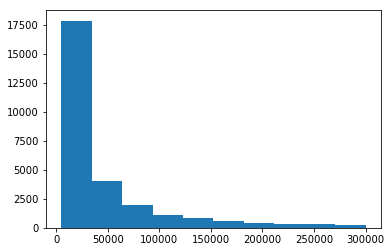

In [66]:
plt.hist(obs_gpm.area, range=(5000,300000))

(array([29592.,  3909.,  1676.,   868.,   508.,   326.,   225.,   141.,
          107.,    93.]),
 array([  5000.,  34500.,  64000.,  93500., 123000., 152500., 182000.,
        211500., 241000., 270500., 300000.]),
 <a list of 10 Patch objects>)

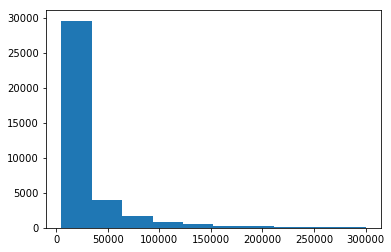

In [67]:
plt.hist(hist.area, range=(5000,300000))

Text(0.5,1,'-0.53')

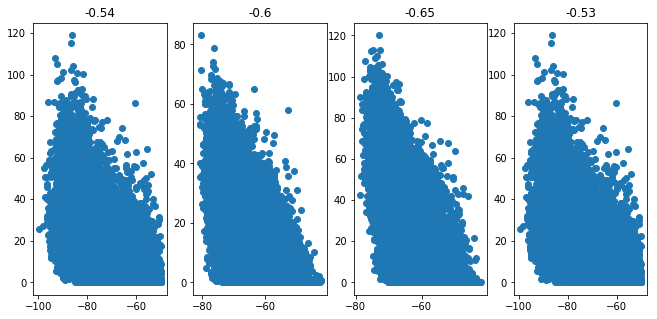

In [68]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 
gpc = [obs_gpc.tmin, obs_gpc.prcp] # gpm


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(144)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)




Text(0.5,1,'-0.8')

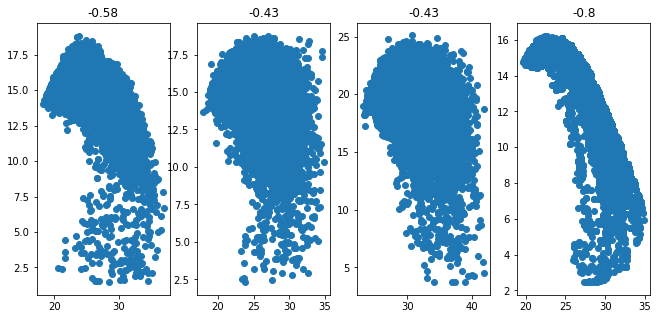

In [69]:

cp4s = [obs_gpm.t925, obs_gpm.q925] # gpm
cp25s = [hist.t925, hist.q925] #cp4
futur = [fut.t925, fut.q925] #cp4

gpc = [obs_gpc.t925, obs_gpc.q925] # gpm


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(144)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5,1,'0.51')

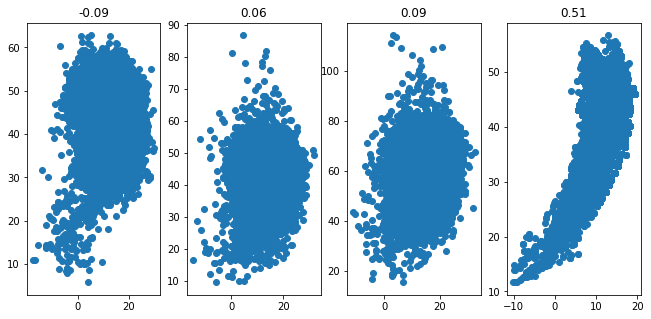

In [78]:

cp4s = [obs_gpm.shear, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4

gpc = [obs_gpc.shear, obs_gpc.tcwv] # gpm


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))


ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(144)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [79]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

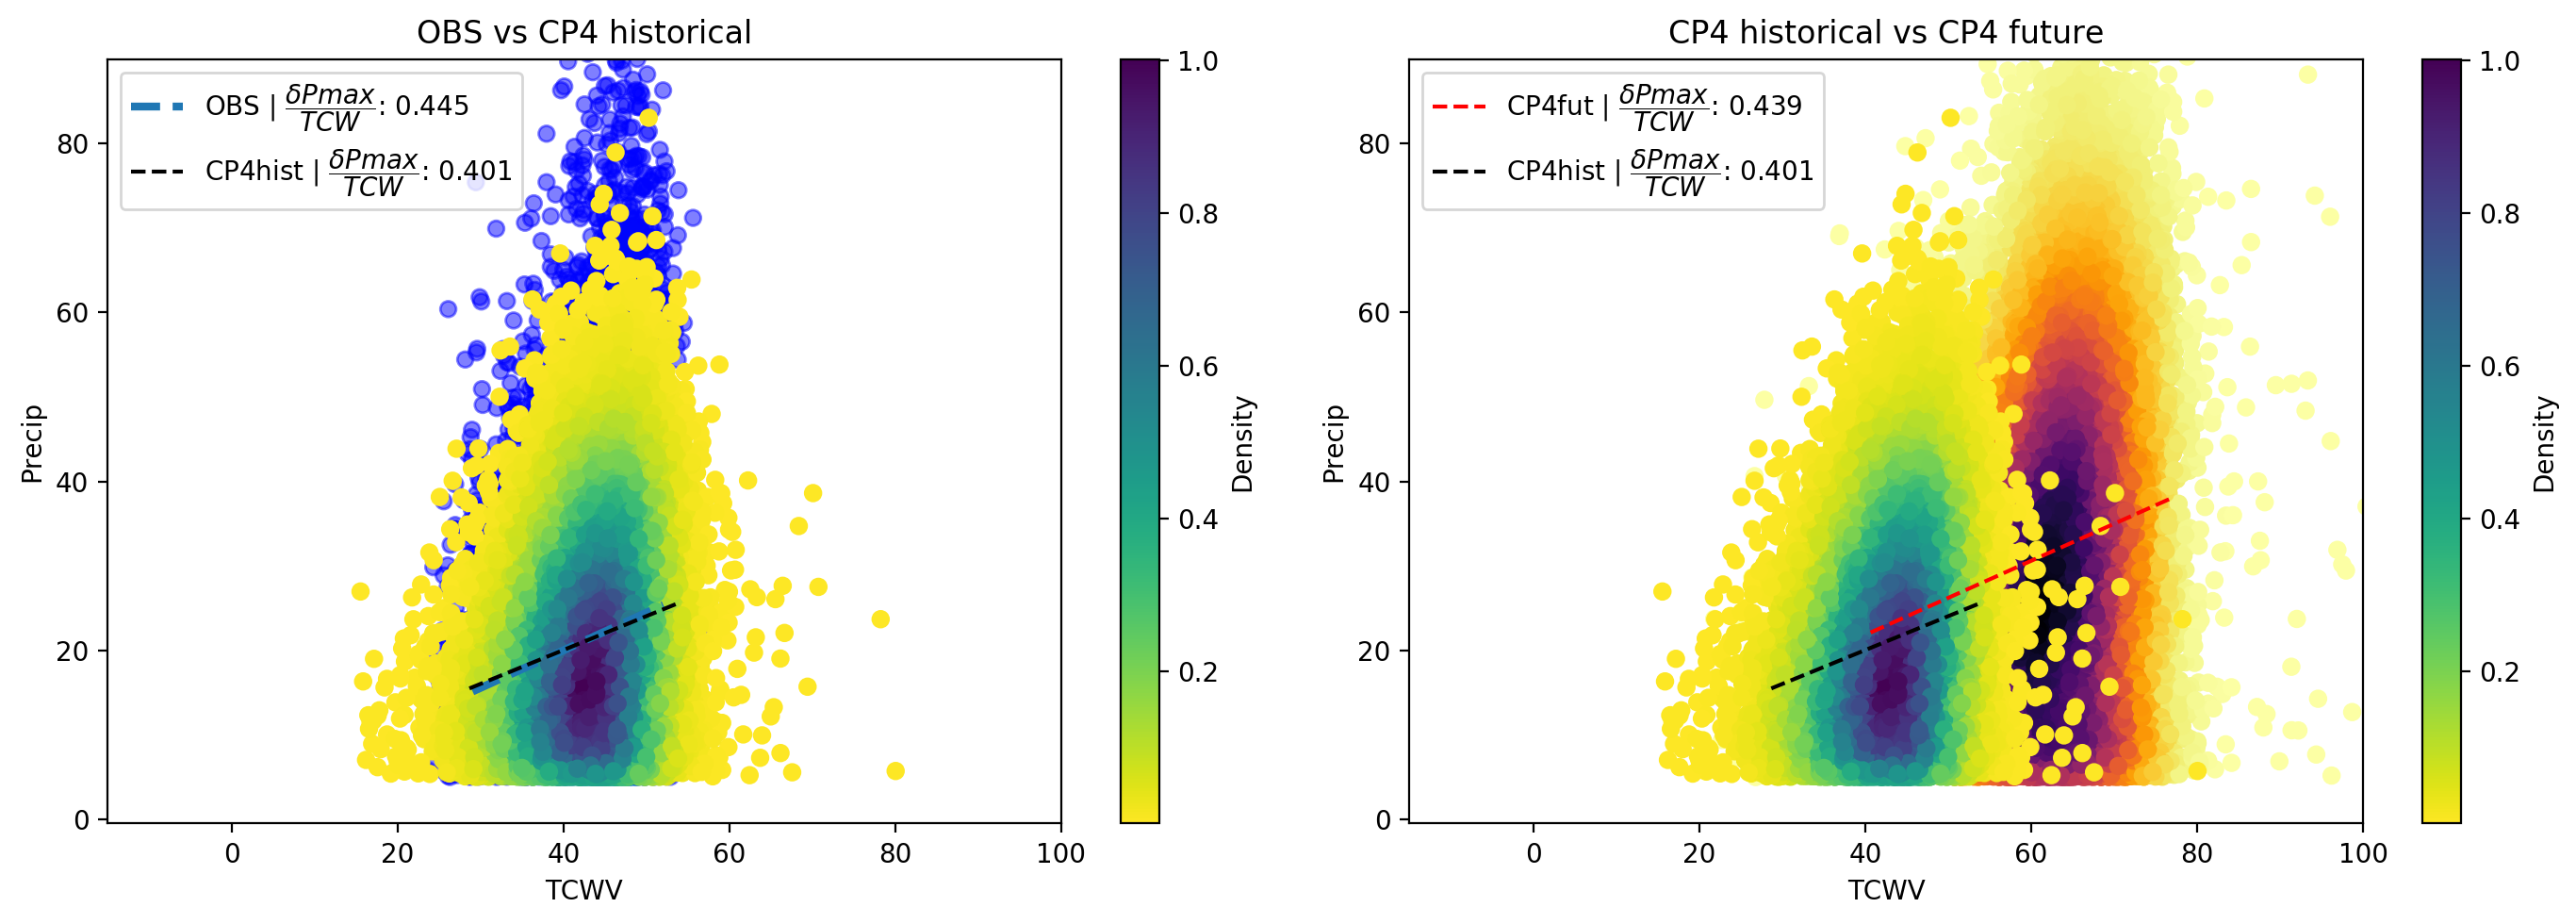

In [83]:
obs = obs_gpc
gpm = [obs.tcwv[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=8)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=8)]] # gpm
cp4h = [hist.tcwv[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=8)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=8)]] #cp4
cp4f = [fut.tcwv[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=8)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=8)]] #cp4

def statsi(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = statsi(gpm[0], gpm[1])
hdata,hslope, hintercept = statsi(cp4h[0], cp4h[1])
fdata,fslope, fintercept = statsi(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])


perc = np.percentile(gpm[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')



perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/CLOVER/precip_tcw_scatter_'+tag+'_ALL.png')

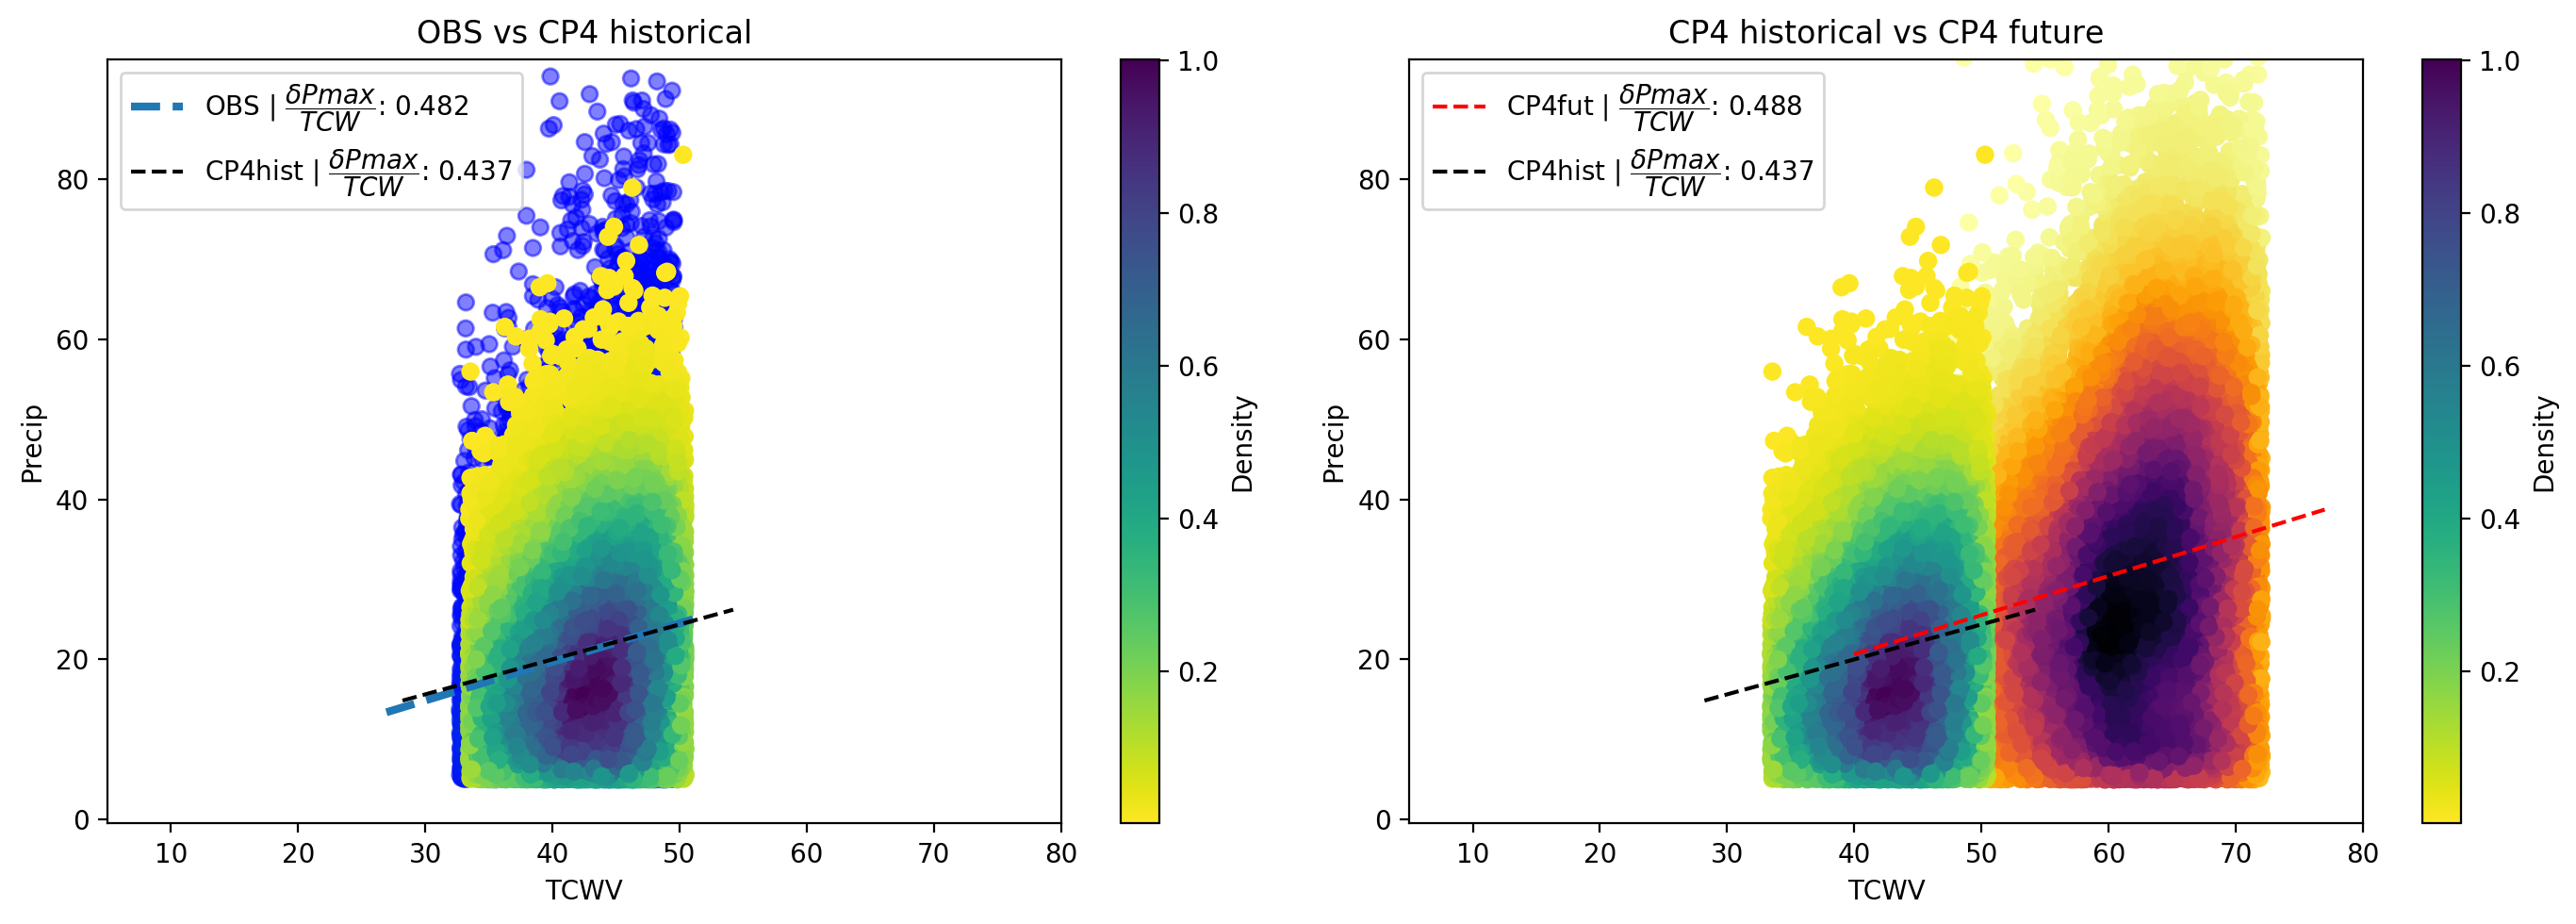

In [101]:
obs = obs_gpc
gpm = [obs.tcwv[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=5)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=5)]] # gpm
cp4h = [hist.tcwv[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=5)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=5)]] #cp4
cp4f = [fut.tcwv[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=5)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=5)]] #cp4

plotgperc = np.percentile(gpm[0],[1,99])
plothperc = np.percentile(cp4h[0],[1,99])
plotfperc = np.percentile(cp4f[0],[1,99])


gpmp = np.percentile(gpm[0], [5,93])
cp4hp  = np.percentile(cp4h[0], [5,93])
cp4fp = np.percentile(cp4f[0], [5,93])

gmask = (gpm[0]>=gpmp[0])&(gpm[0]<=gpmp[1])
hmask = (cp4h[0]>=cp4hp[0])&(cp4h[0]<=cp4hp[1])
fmask = (cp4f[0]>=cp4fp[0])&(cp4f[0]<=cp4fp[1])

pgmask = (gpm[1]<=np.percentile(gpm[1], 98))
phmask = (cp4h[1]<=np.percentile(cp4h[1], 98))
pfmask = (cp4f[1]<=np.percentile(cp4f[1], 98))

#ipdb.set_trace()

gpm[0] = gpm[0][gmask]#&pgmask]
cp4h[0] = cp4h[0][hmask]#&phmask]
cp4f[0] = cp4f[0][fmask]#&pfmask]
gpm[1] = gpm[1][gmask]#&pgmask]
cp4h[1] = cp4h[1][hmask]#&phmask]
cp4f[1] = cp4f[1][fmask]#&pfmask]


def statsi(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = statsi(gpm[0], gpm[1])
hdata,hslope, hintercept = statsi(cp4h[0], cp4h[1])
fdata,fslope, fintercept = statsi(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])



plt.plot(np.arange(plotgperc[0],plotgperc[1]), np.arange(plotgperc[0],plotgperc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(plothperc[0],plothperc[1]), np.arange(plothperc[0],plothperc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[0,100])
plt.plot(np.arange(plotfperc[0],plotfperc[1]), np.arange(plotfperc[0],plotfperc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')


perc = np.percentile(cp4h[0],[0,100])
plt.plot(np.arange(plothperc[0],plothperc[1]), np.arange(plothperc[0],plothperc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/CLOVER/precip_tcw_scatter_'+tag+'.png')

In [ ]:
obs = obs_gpc
gpm = [obs.q925[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=1)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=1)]] # gpm
cp4h = [hist.q925[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=1)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=1)]] #cp4
cp4f = [fut.q925[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=1)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=1)]] #cp4

def stats(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = stats(gpm[0], gpm[1])
hdata,hslope, hintercept = stats(cp4h[0], cp4h[1])
fdata,fslope, fintercept = stats(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])


perc = np.percentile(gpm[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')



perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/CLOVER/precip_q_scatter_'+tag+'_ALL.png')

In [ ]:
maskgpm = np.isfinite(obs_gpm.tgrad)
maskcp4 = np.isfinite(hist.tgrad) & (hist.tgrad<=0.6)
cp4s = [obs_gpm.shear[maskgpm], obs_gpm.tgrad[maskgpm]] # gpm
cp25s = [hist.shear[maskcp4], hist.tgrad[maskcp4]] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)


In [ ]:
cp4s = [obs_gpm.rh, obs_gpm.prcp] #cp4
cp25s = [obs_gpc.rh, obs_gpc.prcp] # gpm


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(143)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('CP4hist: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')
#ax.set_ylim(0,50)

In [ ]:
maskgpm = np.isfinite(obs_gpm.tbox)
maskcp4 = np.isfinite(hist.tbox) & (hist.tbox<=10)
cp4s = [obs_gpm.shear[maskgpm], obs_gpm.tbox[maskgpm]] # gpm
cp25s = [hist.shear[maskcp4], hist.tbox[maskcp4]] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [ ]:

cp4s = [obs_gpm.tcwv, obs_gpm.prcp] # gpm
cp25s = [hist.tcwv, hist.prcp] #cp4
futur = [fut.tcwv, fut.prcp] #cp4
gpc = [obs_gpc.tcwv, obs_gpc.prcp] # gpm


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(143)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('CP4hist: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')
#ax.set_ylim(0,50)

ax = f.add_subplot(144)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title('CP4fut: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(142)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title('OBSclim: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

plt.tight_layout()

In [ ]:

cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [hist.q925, hist.prcp] #cp4
futur = [fut.q925, fut.prcp] #cp4
gpc = [obs_gpc.q925, obs_gpc.prcp] # gpm


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Low-level q')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(143)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('CP4hist: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Low-level q')
plt.ylabel('Precip (mm h-1)')
#ax.set_ylim(0,50)

ax = f.add_subplot(144)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title('CP4fut: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Low-level q')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(142)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title('OBSclim: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Low-level q')
plt.ylabel('Precip (mm h-1)')

plt.tight_layout()

In [ ]:

cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [hist.q925, hist.prcp] #cp4
futur = [fut.q925, fut.prcp] #cp4
gpc = [obs_gpc.q925, obs_gpc.prcp] # gpm


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(144)
plt.scatter(gpc[0],gpc[1])
r = stats.pearsonr(gpc[0],gpc[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [ ]:

cp4s = [(obs_gpm.shear)[obs_gpm.shear>-2], obs_gpm.q925[obs_gpm.shear>-2]] # gpm
cp25s = [(hist.shear)[hist.shear>-2], hist.q925[hist.shear>-2]] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)



In [ ]:
obss = [hist.q925[hist.thetamax>=-40], hist.thetamax[hist.thetamax>=-40]] # cp4
cp4s = [obs_gpc.q925, obs_gpc.theta_e] # gpm



f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))



ax = f.add_subplot(122)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [ ]:

cp4s = [obs_gpc.shear, obs_gpc.prcp] # gpm
cp25s = [hist.shear, hist.prcp] #cp4
futur = [fut.shear, fut.prcp]


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS '+str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('Hist '+ str(np.round(r[0], decimals=2)))

ax = f.add_subplot(133)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title('Fut '+ str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)


In [ ]:
obss = [hist.shear, hist.thetamax, hist.q925, hist.tmin, hist.prcp, '', '', hist.tcwv] # cp4
cp4s = [obs_gpm.shear, obs_gpm.theta_e, obs_gpm.q925, obs_gpm.tmin, obs_gpm.prcp, obs_gpm.q650,  obs_gpm.t650, obs_gpm.tcwv]  # gpm

f = plt.figure(figsize=(15,8))
ax = f.add_subplot(2,5,1)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,2)
r = stats.pearsonr(cp4s[0],cp4s[2])
plt.scatter(cp4s[0],cp4s[2])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,3)
r = stats.pearsonr(cp4s[2],cp4s[1])
plt.scatter(cp4s[2],cp4s[1])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,4)
r = stats.pearsonr(cp4s[2],cp4s[4])
plt.scatter(cp4s[2],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('precip')


ax = f.add_subplot(2,5,6)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,7)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[2])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,8)
plt.scatter(obss[2],obss[1])
r = stats.pearsonr(obss[2],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,9)
r = stats.pearsonr(obss[2],obss[4])
plt.scatter(obss[2],obss[4])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('precip')

ax = f.add_subplot(2,5,5)
plt.scatter(cp4s[7],cp4s[4])
r = stats.pearsonr(cp4s[7],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

ax = f.add_subplot(2,5,10)
r = stats.pearsonr(obss[7],obss[4])
plt.scatter(obss[7],obss[4])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

plt.tight_layout()
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_SoudanoSahel_OBS_CP4.png')

In [ ]:
obss = [fut.shear, fut.thetamax, fut.q925, fut.tmin, fut.prcp, '', '', fut.tcwv] # cp4
cp4s = [obs_gpm.shear, obs_gpm.theta_e, obs_gpm.q925, obs_gpm.tmin, obs_gpm.prcp, obs_gpm.q650,  obs_gpm.t650, obs_gpm.tcwv]  # gpm

f = plt.figure(figsize=(15,8))
ax = f.add_subplot(2,5,1)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,2)
r = stats.pearsonr(cp4s[0],cp4s[2])
plt.scatter(cp4s[0],cp4s[2])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,3)
r = stats.pearsonr(cp4s[2],cp4s[1])
plt.scatter(cp4s[2],cp4s[1])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,4)
r = stats.pearsonr(cp4s[2],cp4s[4])
plt.scatter(cp4s[2],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('precip')


ax = f.add_subplot(2,5,6)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,7)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[2])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,8)
plt.scatter(obss[2],obss[1])
r = stats.pearsonr(obss[2],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,9)
r = stats.pearsonr(obss[2],obss[4])
plt.scatter(obss[2],obss[4])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('precip')

ax = f.add_subplot(2,5,5)
plt.scatter(cp4s[7],cp4s[4])
r = stats.pearsonr(cp4s[7],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

ax = f.add_subplot(2,5,10)
r = stats.pearsonr(obss[7],obss[4])
plt.scatter(obss[7],obss[4])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

plt.tight_layout()
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [ ]:
oposi = (obs_gpm.q925>=9.5) & (obs_gpm.shear>-5) &  (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-60) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
ooposi = (obs_gpc.q925>=9.5) & (obs_gpc.shear>-5) &  (obs_gpc.prcp>=5) & (obs_gpc.theta_e>=-40) & (obs_gpc.area>=5000) & (obs_gpc.tmin<=-60)
cposi = (hist.q925>=9.5) & (hist.shear>-5) &  (hist.prcp>=5) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-60)
fposi = (fut.q925>=9.5) & (fut.shear>-5) &  (fut.prcp>=5) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-60)

In [51]:
obs = obs_gpm[oposi]
obsc = obs_gpc[ooposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [52]:
cp4.area.min()

5014.240000000001

In [53]:
obs.area.min()

5150

In [54]:
obsc.area.min()

5150

In [55]:
obs.keys()

Index(['prcp', 'q925', 'q650', 't925', 'shear', 'month', 'area', 'tmin', 'rh',
       'theta_e', 'tcwv', 'tgrad', 'tbox', 'lat', 'lon'],
      dtype='object')

In [56]:
len(obs)

21436

In [57]:
len(obsc)

22663

In [58]:
len(cp4)

24610

In [59]:
len(cp4f)

18665

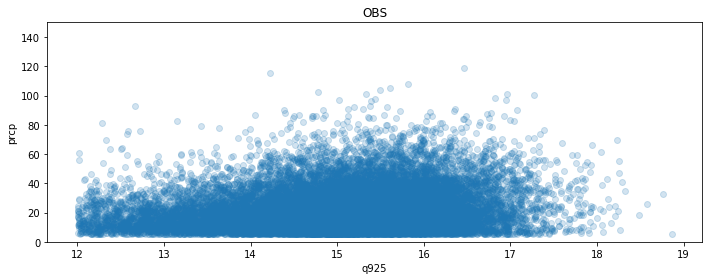

In [60]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obs.q925>12
plt.scatter(obs.where(isqq).q925, obs.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

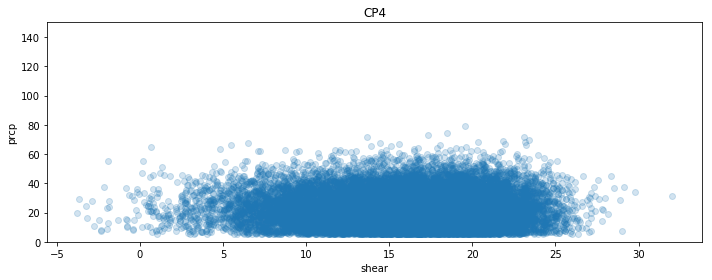

In [61]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = cp4.q925>12
plt.scatter(cp4.where(isqq).shear, cp4.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('CP4')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

In [62]:
print(obs['q925'].median())
print(obs['shear'].median())
print(obs['prcp'].median())
print(obs['tmin'].median())
print(obs['theta_e'].median())

15.03920741379261
13.866950511932373
18.30874117946559
-78.75406411092928
-0.2673245160271449


In [63]:
print(obs['q925'].mean())
print(obs['shear'].mean())
print(obs['prcp'].mean())
print(obs['tmin'].mean())
print(obs['theta_e'].mean())

14.849335218111186
13.453108285029092
21.933405884332824
-78.04260191285627
-0.34802098745362603


In [64]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    for isq, qql in enumerate(ybins[0:-1]):

        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.tmin[poss_ds]))
                if ds_val < 5:
                    ds_mean = np.nan
                else:
                    ds_mean = ds_mmean/ds_val          
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(ds.prcp[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan
                
            try:
                ds_ammean = np.nansum(ds.area[poss_ds])
                area_val = np.sum(np.isfinite(ds.area[poss_ds]))
                if area_val < 5:
                    ds_amean = np.nan
                else:
                    ds_amean = ds_ammean/area_val  
            except IndexError:
                ds_amean = np.nan
            
            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval, outarea_ds

In [65]:
def create_2dhist_tcwv(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    for isq, qql in enumerate(ybins[0:-1]):

        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.tcwv>=qql) & (ds.tcwv < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.tmin[poss_ds]))
                if ds_val < 5:
                    ds_mean = np.nan
                else:
                    ds_mean = ds_mmean/ds_val          
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(ds.prcp[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan
                
            try:
                ds_ammean = np.nansum(ds.area[poss_ds])
                area_val = np.sum(np.isfinite(ds.area[poss_ds]))
                if area_val < 5:
                    ds_amean = np.nan
                else:
                    ds_amean = ds_ammean/area_val  
            except IndexError:
                ds_amean = np.nan
            
            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval, outarea_ds

In [66]:
def create_2dhist_theta(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    if 'theta_e' in ds.keys():
        tvar = 'theta_e'
    else:
        tvar = 'thetamax'
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds[tvar]>=qql) & (ds[tvar] < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.tmin[poss_ds]))
                if ds_val < 5:  #2
                    ds_mean = np.nan
                else:
                    ds_mean = ds_mmean/ds_val          
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(ds.prcp[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan

            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp,  outval

In [67]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [68]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_'+tag+'_15km_future.png')

In [71]:
obsT, obsP,  obsVAL, obsAREA = create_2dhist(obs, shearbins, qbins)
wvobsT, wvobsP,  wvobsVAL, wvobsAREA = create_2dhist_tcwv(obs, shearbins, tcwvbins)
tobsT, tobsP,  tobsVAL = create_2dhist_theta(obs, shearbins, thetabins)

In [72]:
obscT, obscP,  obscVAL, obscAREA = create_2dhist(obsc, shearbins, qbins)
wvobscT, wvobscP,  wvobscVAL, wvobscAREA = create_2dhist_tcwv(obsc, shearbins, tcwvbins)
tobscT, tobscP,  tobscVAL = create_2dhist_theta(obsc, shearbins, thetabins)

In [73]:
T4, P4,  VAL4, area4 = create_2dhist(cp4, shearbins, qbins)
wvT4, wvP4,  wvVAL4, wvarea4 = create_2dhist_tcwv(cp4, shearbins, tcwvbins)
tT4, tP4,  tVAL4 = create_2dhist_theta(cp4, shearbins, thetabins)

In [74]:
T4f, P4f,  VAL4f, area4f = create_2dhist(cp4f, shearbins, qbins)
wvT4f, wvP4f,  wvVAL4f, wvarea4f = create_2dhist_tcwv(cp4f, shearbins, tcwvbins)
tT4f, tP4f,  tVAL4f = create_2dhist_theta(cp4f, shearbins, thetabins)

In [75]:
tvmin = -83
tvmax = -64

pvmin = 17
pvmax = 27

avmin = 5000
avmax = 90500

thetatmin_dic_obs = {
    'data' : tobsT,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : tobsVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tmin_dic_obs = {
    'data' : obsT,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : obsVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


wvtmin_dic_obs = {
    'data' : wvobsT,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : wvobsVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



obsP[obsP==0]=np.nan
prcp_dic_obs = {
    'data' : obsP,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : obsVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


wvobsP[wvobsP==0]=np.nan
wvprcp_dic_obs = {
    'data' : wvobsP,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : wvobsVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tobsP[tobsP==0]=np.nan
thetaprcp_dic_obs = {
    'data' : tobsP,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : tobsVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


area_dic = {
    'data' : obsAREA,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: MCS area',
    'valid' : obsVAL,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin, 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-2}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [76]:
tvmin = -83
tvmax = -64

pvmin = 17
pvmax = 27

avmin = 5000
avmax = 90500

thetatmin_dic_obsc = {
    'data' : tobscT,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : tobscVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tmin_dic_obsc = {
    'data' : obscT,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : obscVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


wvtmin_dic_obsc = {
    'data' : wvobscT,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: minimum temperature',
    'valid' : wvobscVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



obscP[obscP==0]=np.nan
prcp_dic_obsc = {
    'data' : obscP,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : obscVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



wvobscP[wvobscP==0]=np.nan
wvprcp_dic_obsc = {
    'data' : wvobscP,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : wvobscVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tobscP[tobscP==0]=np.nan
thetaprcp_dic_obsc = {
    'data' : tobscP,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: maximum precipitation',
    'valid' : tobscVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


area_dic = {
    'data' : obscAREA,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: MCS area',
    'valid' : obscVAL,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin, 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-2}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [77]:

############T: q shear
data = T4
tmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: minimum temperature',
    'valid' : VAL4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


data = wvT4
wvtmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: minimum temperature',
    'valid' : wvVAL4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



############Area: q shear
data = area4
area_dic_cp4 = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: MCS area',
    'valid' : VAL4,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin , 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

#######T: theta shear
data =tT4
thetatmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4: minimum temperature',
    'valid' : tVAL4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax,
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: q shear
P4[P4==0]=np.nan
data = P4
prcp_dic_cp4 = {
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: maximum precipitation',
    'valid' : VAL4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



############Precip: tcwv shear
wvP4[wvP4==0]=np.nan
data = wvP4
wvprcp_dic_cp4 = {
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: maximum precipitation',
    'valid' : wvVAL4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: theta shear
tP4[tP4==0]=np.nan
data = tP4
thetaprcp_dic_cp4 = {
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4: maximum precipitation',
    'valid' : tVAL4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin,
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [78]:

############T: q shear
data = T4f
tmin_dic_cp4f = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4f: minimum temperature',
    'valid' : VAL4f,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############T: tcwv shear
data = wvT4f
wvtmin_dic_cp4f = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4f: minimum temperature',
    'valid' : wvVAL4f,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

############Area: q shear
data = area4f
area_dic_cp4f = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4f: MCS area',
    'valid' : VAL4f,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin , 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

#######T: theta shear
data =tT4f
thetatmin_dic_cp4f = {
    
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4f: minimum temperature',
    'valid' : tVAL4f,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax,
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: q shear
P4f[P4f==0]=np.nan
data = P4f
prcp_dic_cp4f = {
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4f: maximum precipitation',
    'valid' : VAL4f,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: tcwv shear
wvP4f[wvP4f==0]=np.nan
data = wvP4f
wvprcp_dic_cp4f = {
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4f: maximum precipitation',
    'valid' : wvVAL4f,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: theta shear
tP4f[tP4f==0]=np.nan
data = tP4f
thetaprcp_dic_cp4f = {
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4f: maximum precipitation',
    'valid' : tVAL4f,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin,
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [79]:
shearscat = np.repeat(shearbins,obsP.shape[0],axis=0).reshape(obsP.shape)

In [80]:
qscat = np.repeat(qbins[np.newaxis,:],obsP.shape[0],axis=0).reshape(obsP.shape)

In [81]:
wvscat = np.repeat(tcwvbins[np.newaxis,:],obsP.shape[0],axis=0).reshape(obsP.shape)

In [82]:
thetascat = np.repeat(thetabins[np.newaxis,:],obsP.shape[0],axis=0).reshape(obsP.shape)

In [83]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    for sh in np.unique(bins):

            vals = prcp[sh==bins]
            tvals = tmin[sh==bins]
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
#             if nans > 1:
#                 vv = np.nan
            
            mean.append(vv)
            try:
                percup.append(np.percentile(vals[np.isfinite(vals)],75))
                percdown.append(np.percentile(vals[np.isfinite(vals)],25))
            except:
                percup.append(np.nan)
                percdown.append(np.nan)
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
#             if nans > 2:
#                 tt = np.nan
            tmean.append(tt)
            try:
                tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
            except:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
               
            
            
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown

In [84]:
deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10 = binning_2dhist(obsP, obsT, shearscat)
deltaPSc, deltaQPSc, sboxplotc, tminboxc,pmeanc,p90c,p10c, tmeanc, t90c, t10c = binning_2dhist(obscP, obscT, shearscat)
deltaPS4, deltaQPS4, sboxplot4, tminbox4,pmean4,p904,p104, tmean4, t904, t104 = binning_2dhist(P4, T4, shearscat)
deltaPS4f, deltaQPS4f, sboxplot4f, tminbox4f,pmean4f,p904f,p104f, tmean4f, t904f, t104f = binning_2dhist(P4f, T4f, shearscat)

6.162703398337998
3.5493894798634322
4.053367827188124
4.879456516965604


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [85]:
deltaPQ, deltaQPQ, boxplotq, tminboxq,pqmean,pq90,pq10, tqmean, tq90, tq10 = binning_2dhist(obsP, obsT, qscat)
deltaPQc, deltaQPQc, boxplotqc, tminboxqc,pqmeanc,pq90c,pq10c, tqmeanc, tq90c, tq10c = binning_2dhist(obscP, obscT, qscat)
deltaPQ4, deltaQPQ4, boxplotq4, tminboxq4,pqmean4,pq904,pq104,tqmean4, tq904, tq104 = binning_2dhist(P4, T4, qscat)
deltaPQ4f, deltaQPQ4f, boxplotq4f, tminboxq4f,pqmean4f,pq904f,pq104f,tqmean4f, tq904f, tq104f = binning_2dhist(P4f, T4f, qscat)

4.018198886722536
2.2271240351084636
1.7129618192099585
3.2600892277177493


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [86]:
deltaPW, deltaQPW, boxplotw, tminboxw,pwmean,pw90,pw10, twmean, tw90, tw10 = binning_2dhist(wvobsP, wvobsT, wvscat)
deltaPWc, deltaQPWc, boxplotwc, tminboxwc,pwmeanc,pw90c,pw10c, twmeanc, tw90c, tw10c = binning_2dhist(wvobscP, wvobscT, wvscat)
deltaPW4, deltaQPW4, boxplotw4, tminboxw4,pwmean4,pw904,pw104,twmean4, tw904, tw104 = binning_2dhist(wvP4, wvT4, wvscat)
deltaPW4f, deltaQPW4f, boxplotw4f, tminboxw4f,pwmean4f,pw904f,pw104f,twmean4f, tw904f, tw104f = binning_2dhist(wvP4f, wvT4f, wvscat)

5.111701518980368
1.7501451636825145
1.2570964413112193
2.464928342667358


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [87]:
thetaPQ, thetaQPQ, boxtheta, tmintheta,meantheta,theta90,theta10, tmeantheta, ttheta90, ttheta10 = binning_2dhist(tobsP, tobsT, thetascat)
thetaPQc, thetaQPQc, boxthetac, tminthetac,meanthetac,theta90c,theta10c, tmeanthetac, ttheta90c, ttheta10c = binning_2dhist(tobscP, tobscT, thetascat)
thetaPQ4, thetaQPQ4, boxtheta4, tmintheta4,meantheta4,theta904,theta104, tmeantheta4, ttheta904, ttheta104 = binning_2dhist(tP4, tT4, thetascat)
thetaPQ4f, thetaQPQ4f, boxtheta4f, tmintheta4f,meantheta4f,theta904f,theta104f, tmeantheta4f, ttheta904f, ttheta104f = binning_2dhist(tP4f, tT4f, thetascat)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


4.470806716075849
2.5654578788599807
1.7062847497574385
3.778454820730147


In [88]:
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
wvcollbins = np.round(np.unique(wvscat),2)
wvcollbins = np.round(wvcollbins[0:-1]+((wvcollbins[1::]-wvcollbins[0:-1])/2),2)
thcollbins = np.round(np.unique(thetascat),2)
thcollbins = np.round(thcollbins[0:-1]+((thcollbins[1::]-thcollbins[0:-1])/2),2)

In [89]:
thcollbins

array([-7.46, -6.6 , -5.72, -4.86, -4.  , -3.12, -2.26, -1.38, -0.51,
        0.36,  1.23,  2.09,  2.96,  3.82,  4.7 ,  5.56])

In [90]:
len(ttheta104f)

17

In [91]:
def linregress(bins,data):
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins[pos]
    indata = data[pos]
    return stats.linregress(inbins, indata)

In [92]:
PSslope, PSintercept, PSr_value, PSp_value, PSstd_err = linregress(scollbins, pmean[0:-1])
PQslope, PQintercept, PQr_value, PQp_value, PQstd_err = linregress(qcollbins, pqmean[0:-1])
PWslope, PWintercept, PWr_value, PWp_value, PWstd_err = linregress(wvcollbins, pwmean[0:-1])
PTslope, PTintercept, PTr_value, PTp_value, PTstd_err = linregress(thcollbins, meantheta[0:-1])

TSslope, TSintercept, TSr_value, TSp_value, TSstd_err = linregress(scollbins, tmean[0:-1])
TQslope, TQintercept, TQr_value, TQp_value, TQstd_err = linregress(qcollbins, tqmean[0:-1])
TWslope, TWintercept, TWr_value, TWp_value, TWstd_err = linregress(wvcollbins, twmean[0:-1])
TTslope, TTintercept, TTr_value, TTp_value, TTstd_err = linregress(thcollbins, tmeantheta[0:-1])

In [93]:
PSslopec, PSinterceptc, PSr_valuec, PSp_valuec, PSstd_errc = linregress(scollbins, pmeanc[0:-1])
PQslopec, PQinterceptc, PQr_valuec, PQp_valuec, PQstd_errc = linregress(qcollbins, pqmeanc[0:-1])
PWslopec, PWinterceptc, PWr_valuec, PWp_valuec, PWstd_errc = linregress(wvcollbins, pwmeanc[0:-1])
PTslopec, PTinterceptc, PTr_valuec, PTp_valuec, PTstd_errc = linregress(thcollbins, meanthetac[0:-1])

TSslopec, TSinterceptc, TSr_valuec, TSp_valuec, TSstd_errc = linregress(scollbins, tmeanc[0:-1])
TQslopec, TQinterceptc, TQr_valuec, TQp_valuec, TQstd_errc = linregress(qcollbins, tqmeanc[0:-1])
TWslopec, TWinterceptc, TWr_valuec, TWp_valuec, TWstd_errc = linregress(wvcollbins, twmeanc[0:-1])
TTslopec, TTinterceptc, TTr_valuec, TTp_valuec, TTstd_errc = linregress(thcollbins, tmeanthetac[0:-1])

In [94]:
PSslope4, PSintercept4, PSr_value4, PSp_value4, PSstd_err4 = linregress(scollbins, pmean4[0:-1])
PQslope4, PQintercept4, PQr_value4, PQp_value4, PQstd_err4 = linregress(qcollbins, pqmean4[0:-1])
PWslope4, PWintercept4, PWr_value4, PWp_value4, PWstd_err4 = linregress(wvcollbins, pwmean4[0:-1])
PTslope4, PTintercept4, PTr_value4, PTp_value4, PTstd_err4 = linregress(thcollbins, meantheta4[0:-1])

TSslope4, TSintercept4, TSr_value4, TSp_value4, TSstd_err4 = linregress(scollbins, tmean4[0:-1])
TQslope4, TQintercept4, TQr_value4, TQp_value4, TQstd_err4 = linregress(qcollbins, tqmean4[0:-1])
TWslope4, TWintercept4, TWr_value4, TWp_value4, TWstd_err4 = linregress(wvcollbins, twmean4[0:-1])
TTslope4, TTintercept4, TTr_value4, TTp_value4, TTstd_err4 = linregress(thcollbins, tmeantheta4[0:-1])

In [95]:
PSslope4f, PSintercept4f, PSr_value4f, PSp_value4f, PSstd_err4f = linregress(scollbins, pmean4f[0:-1])
PQslope4f, PQintercept4f, PQr_value4f, PQp_value4f, PQstd_err4f = linregress(qcollbins, pqmean4f[0:-1])
PWslope4f, PWintercept4f, PWr_value4f, PWp_value4f, PWstd_err4f = linregress(wvcollbins, pwmean4f[0:-1])
PTslope4f, PTintercept4f, PTr_value4f, PTp_value4f, PTstd_err4f = linregress(thcollbins, meantheta4f[0:-1])

TSslope4f, TSintercept4f, TSr_value4f, TSp_value4f, TSstd_err4f = linregress(scollbins, tmean4f[0:-1])
TQslope4f, TQintercept4f, TQr_value4f, TQp_value4f, TQstd_err4f = linregress(qcollbins, tqmean4f[0:-1])
TWslope4f, TWintercept4f, TWr_value4f, TWp_value4f, TWstd_err4f = linregress(wvcollbins, twmean4f[0:-1])
TTslope4f, TTintercept4f, TTr_value4f, TTp_value4f, TTstd_err4f = linregress(thcollbins, tmeantheta4f[0:-1])

In [96]:
PSintercept

16.84071571880532

In [97]:
len(thcollbins)

16

In [98]:
len(theta104)

17

In [99]:
len(theta904)

17

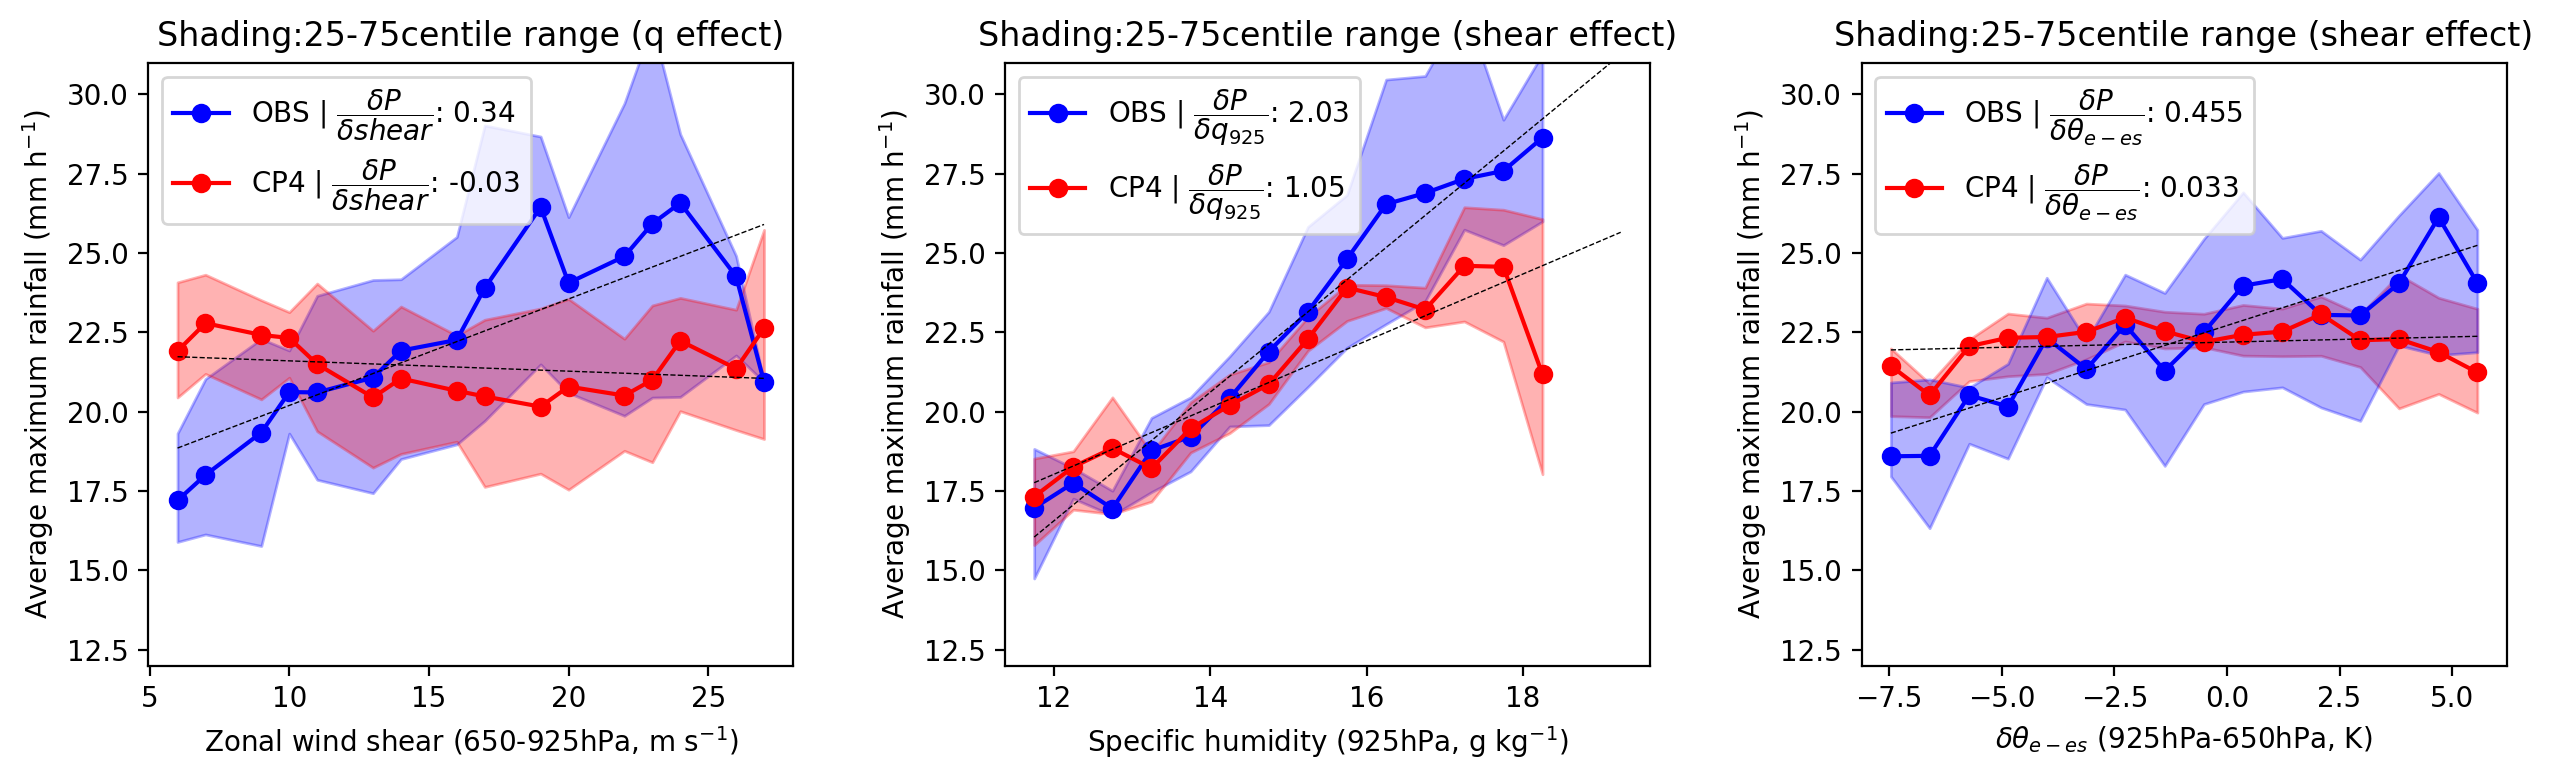

In [100]:
f = plt.figure(figsize=(13,4), dpi=200)
ax = f.add_subplot(131)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.fill_between(scollbins,p10[0:-1],p90[0:-1], color='blue', alpha=0.3)
plt.fill_between(scollbins,p104[0:-1],p904[0:-1], color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4,2)))
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(132)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.fill_between(qcollbins,pq10[0:-1],pq90[0:-1], color='blue', alpha=0.3)
plt.fill_between(qcollbins,pq104[0:-1],pq904[0:-1], color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(133)
plt.plot(thcollbins,meantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope,3)))
plt.fill_between(thcollbins,theta104[0:-1],theta904[0:-1], color='red', alpha=0.3)
plt.fill_between(thcollbins,theta10[0:-1],theta90[0:-1], color='blue', alpha=0.3)
plt.plot(thcollbins,meantheta4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope4,3)))
plt.plot(thcollbins,PTslope*thcollbins+PTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslope4*thcollbins+PTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(12,31)
#plt.ylim(1,33)
plt.legend(loc='upper left')

plt.tight_layout()
#f.savefig(cnst.network_data +'figs/CLOVER/OBS_CP4_lineplot_'+tag+'_15km_rain.png')

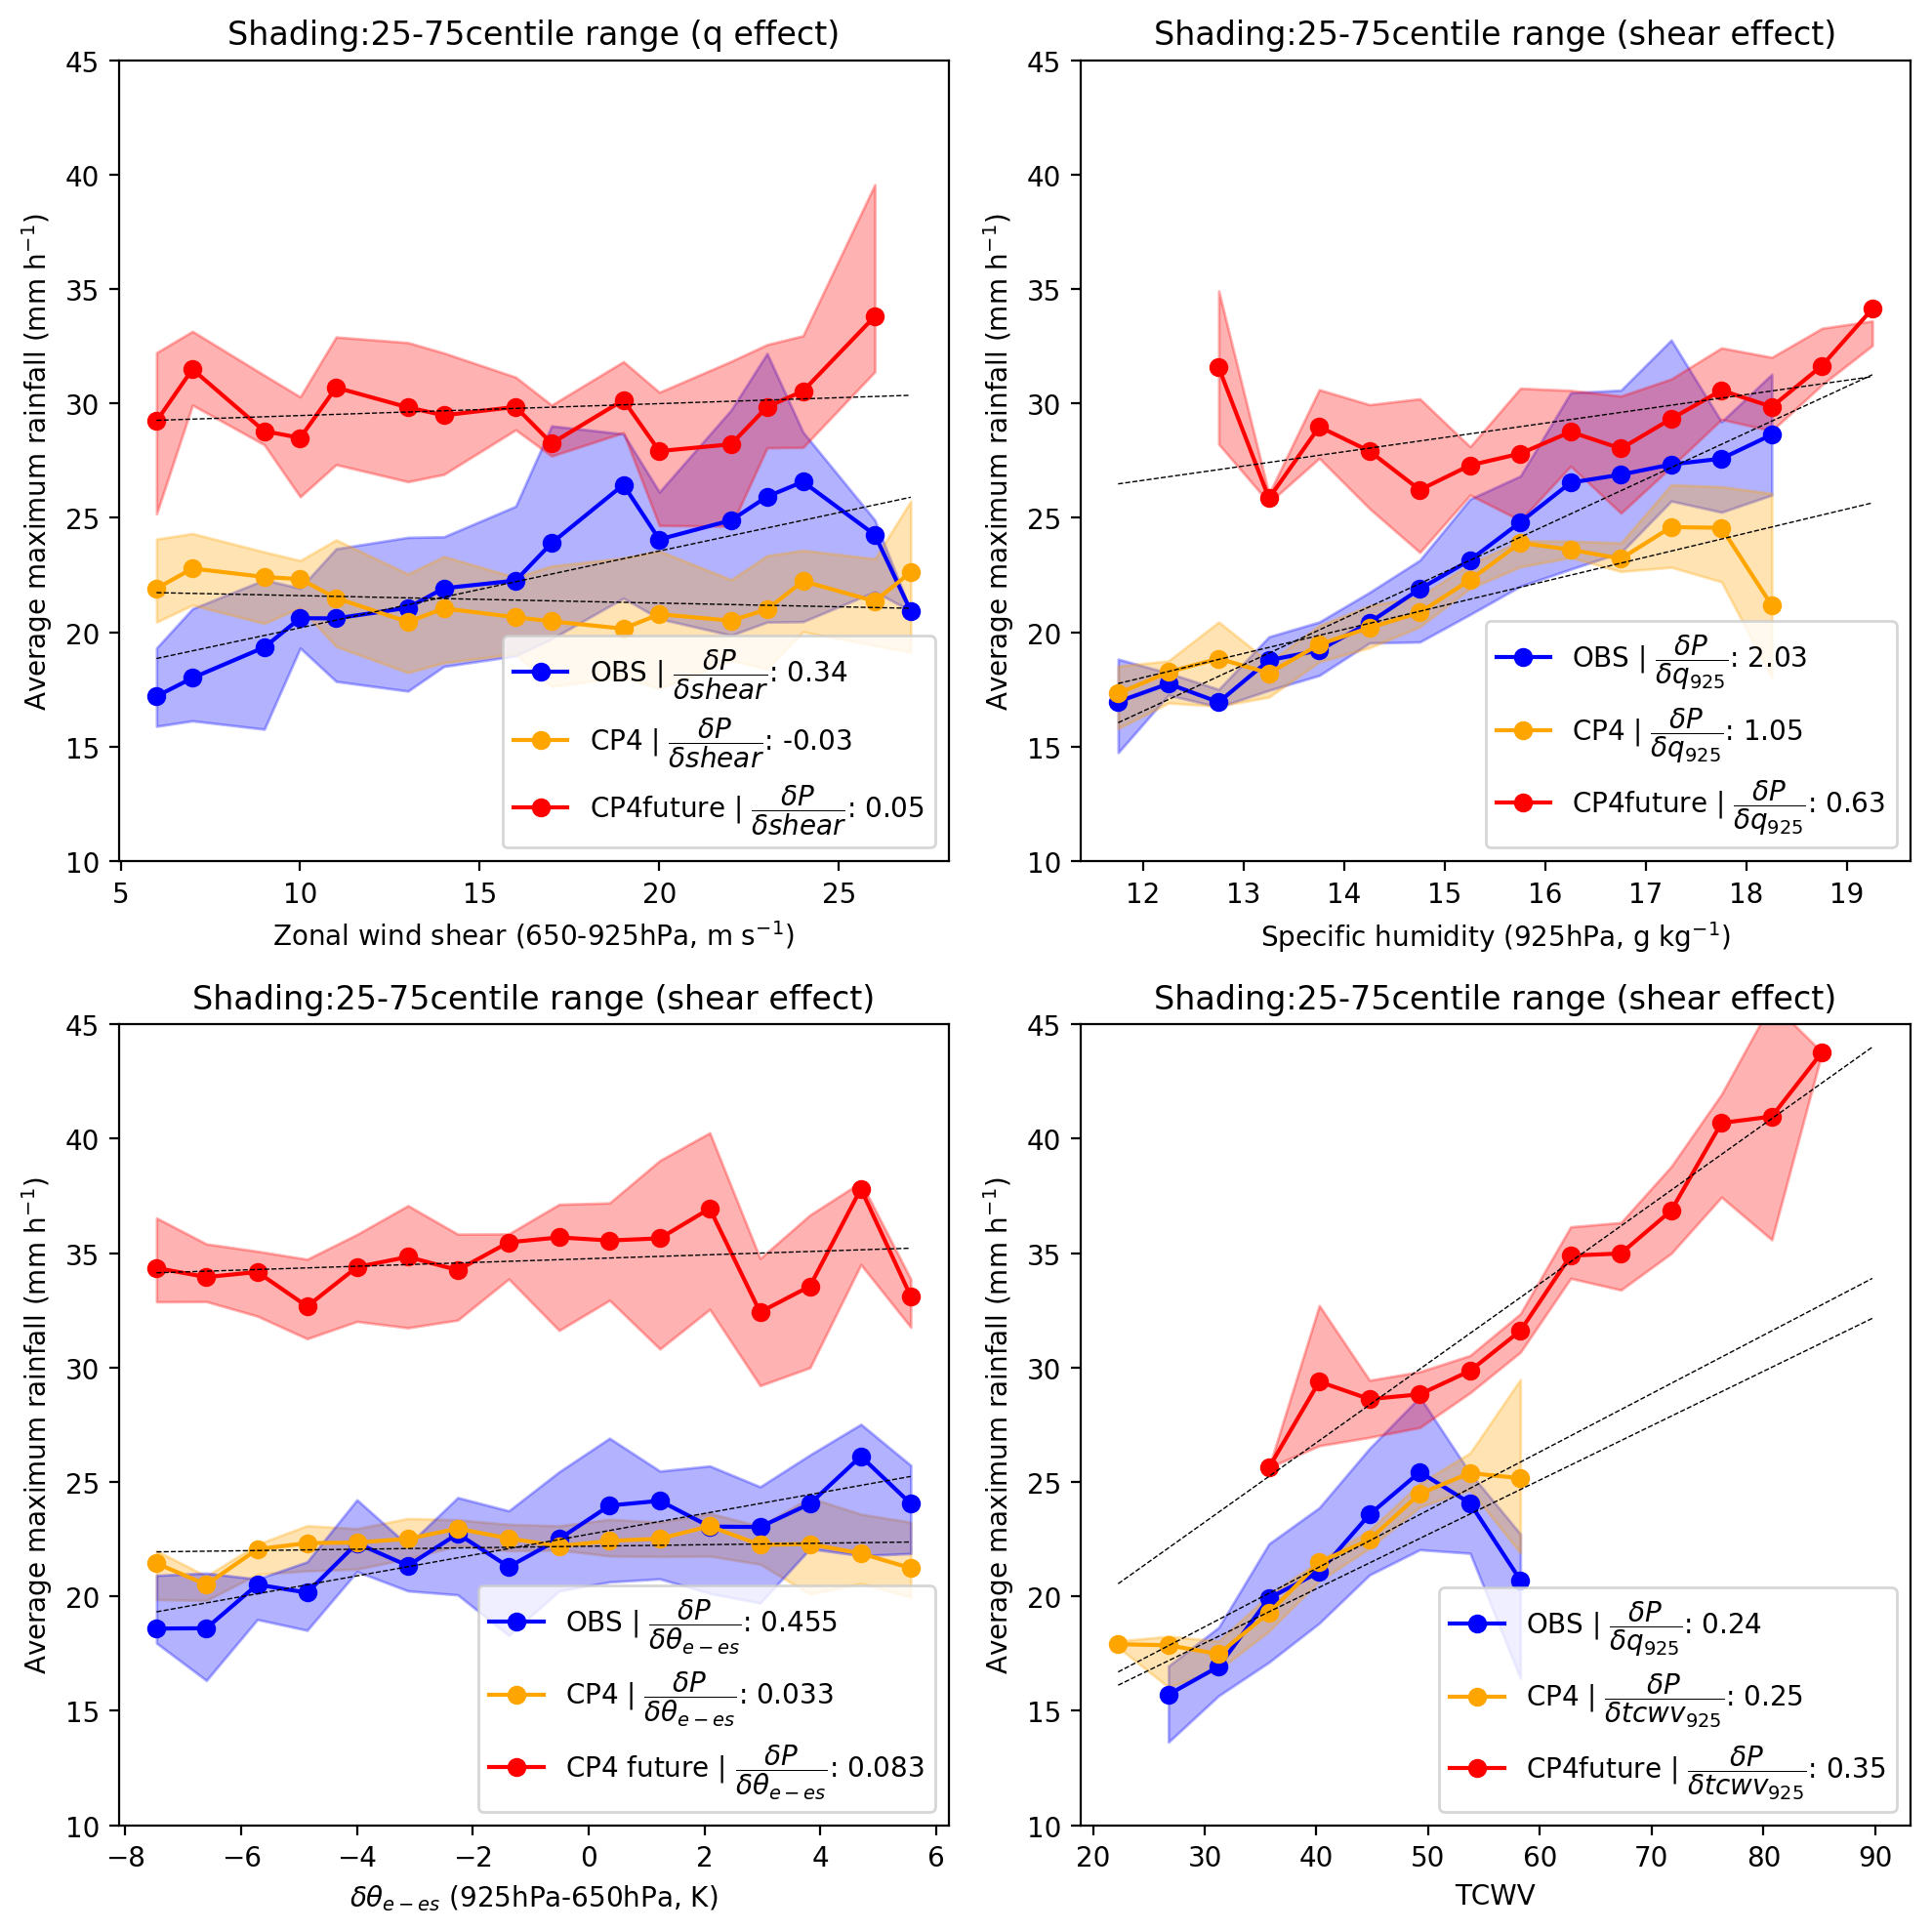

In [102]:
f = plt.figure(figsize=(10,10), dpi=200)
ax = f.add_subplot(221)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.fill_between(scollbins,p10[0:-1],p90[0:-1], color='blue', alpha=0.3)
plt.fill_between(scollbins,p104[0:-1],p904[0:-1], color='orange', alpha=0.3)
plt.fill_between(scollbins,p104f[0:-1],p904f[0:-1], color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], color='orange', marker='o', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4,2)))
plt.plot(scollbins,pmean4f[0:-1], '-ro', label='CP4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4f,2)))
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4f*scollbins+PSintercept4f, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(10,45)
#plt.ylim(15,33)
plt.legend(loc='lower right')

ax = f.add_subplot(222)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.fill_between(qcollbins,pq10[0:-1],pq90[0:-1], color='blue', alpha=0.3)
plt.fill_between(qcollbins,pq104[0:-1],pq904[0:-1], color='orange', alpha=0.3)
plt.fill_between(qcollbins,pq104f[0:-1],pq904f[0:-1], color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,pqmean4f[0:-1], '-ro', label=r'CP4future | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4f,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4f*qcollbins+PQintercept4f, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

plt.ylim(10,45)
#plt.ylim(15,33)
plt.legend(loc='lower right')

ax = f.add_subplot(223)
plt.plot(thcollbins,meantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope,3)))
plt.fill_between(thcollbins,theta104[0:-1],theta904[0:-1], color='orange', alpha=0.3)
plt.fill_between(thcollbins,theta104f[0:-1],theta904f[0:-1], color='red', alpha=0.3)
plt.fill_between(thcollbins,theta10[0:-1],theta90[0:-1], color='blue', alpha=0.3)
plt.plot(thcollbins,meantheta4[0:-1], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope4,3)))
plt.plot(thcollbins,meantheta4f[0:-1], '-ro', label=r'CP4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope4f,3)))
plt.plot(thcollbins,PTslope*thcollbins+PTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslope4*thcollbins+PTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslope4f*thcollbins+PTintercept4f, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(10,45)
#plt.ylim(1,33)
plt.legend(loc='lower right')

ax = f.add_subplot(224)
plt.plot(wvcollbins,pwmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PWslope,2)))
plt.fill_between(wvcollbins,pw10[0:-1],pw90[0:-1], color='blue', alpha=0.3)
plt.fill_between(wvcollbins,pw104[0:-1],pw904[0:-1], color='orange', alpha=0.3)
plt.fill_between(wvcollbins,pw104f[0:-1],pw904f[0:-1], color='red', alpha=0.3)
plt.plot(wvcollbins,pwmean4[0:-1], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(PWslope4,2)))
plt.plot(wvcollbins,pwmean4f[0:-1], '-ro', label=r'CP4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(PWslope4f,2)))
plt.plot(wvcollbins,PWslope*wvcollbins+PWintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(wvcollbins,PWslope4*wvcollbins+PWintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(wvcollbins,PWslope4f*wvcollbins+PWintercept4f, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCWV')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(10,45)
#plt.ylim(1,33)
plt.legend(loc='lower right')

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_fullWA_OBS_CP4future.png')

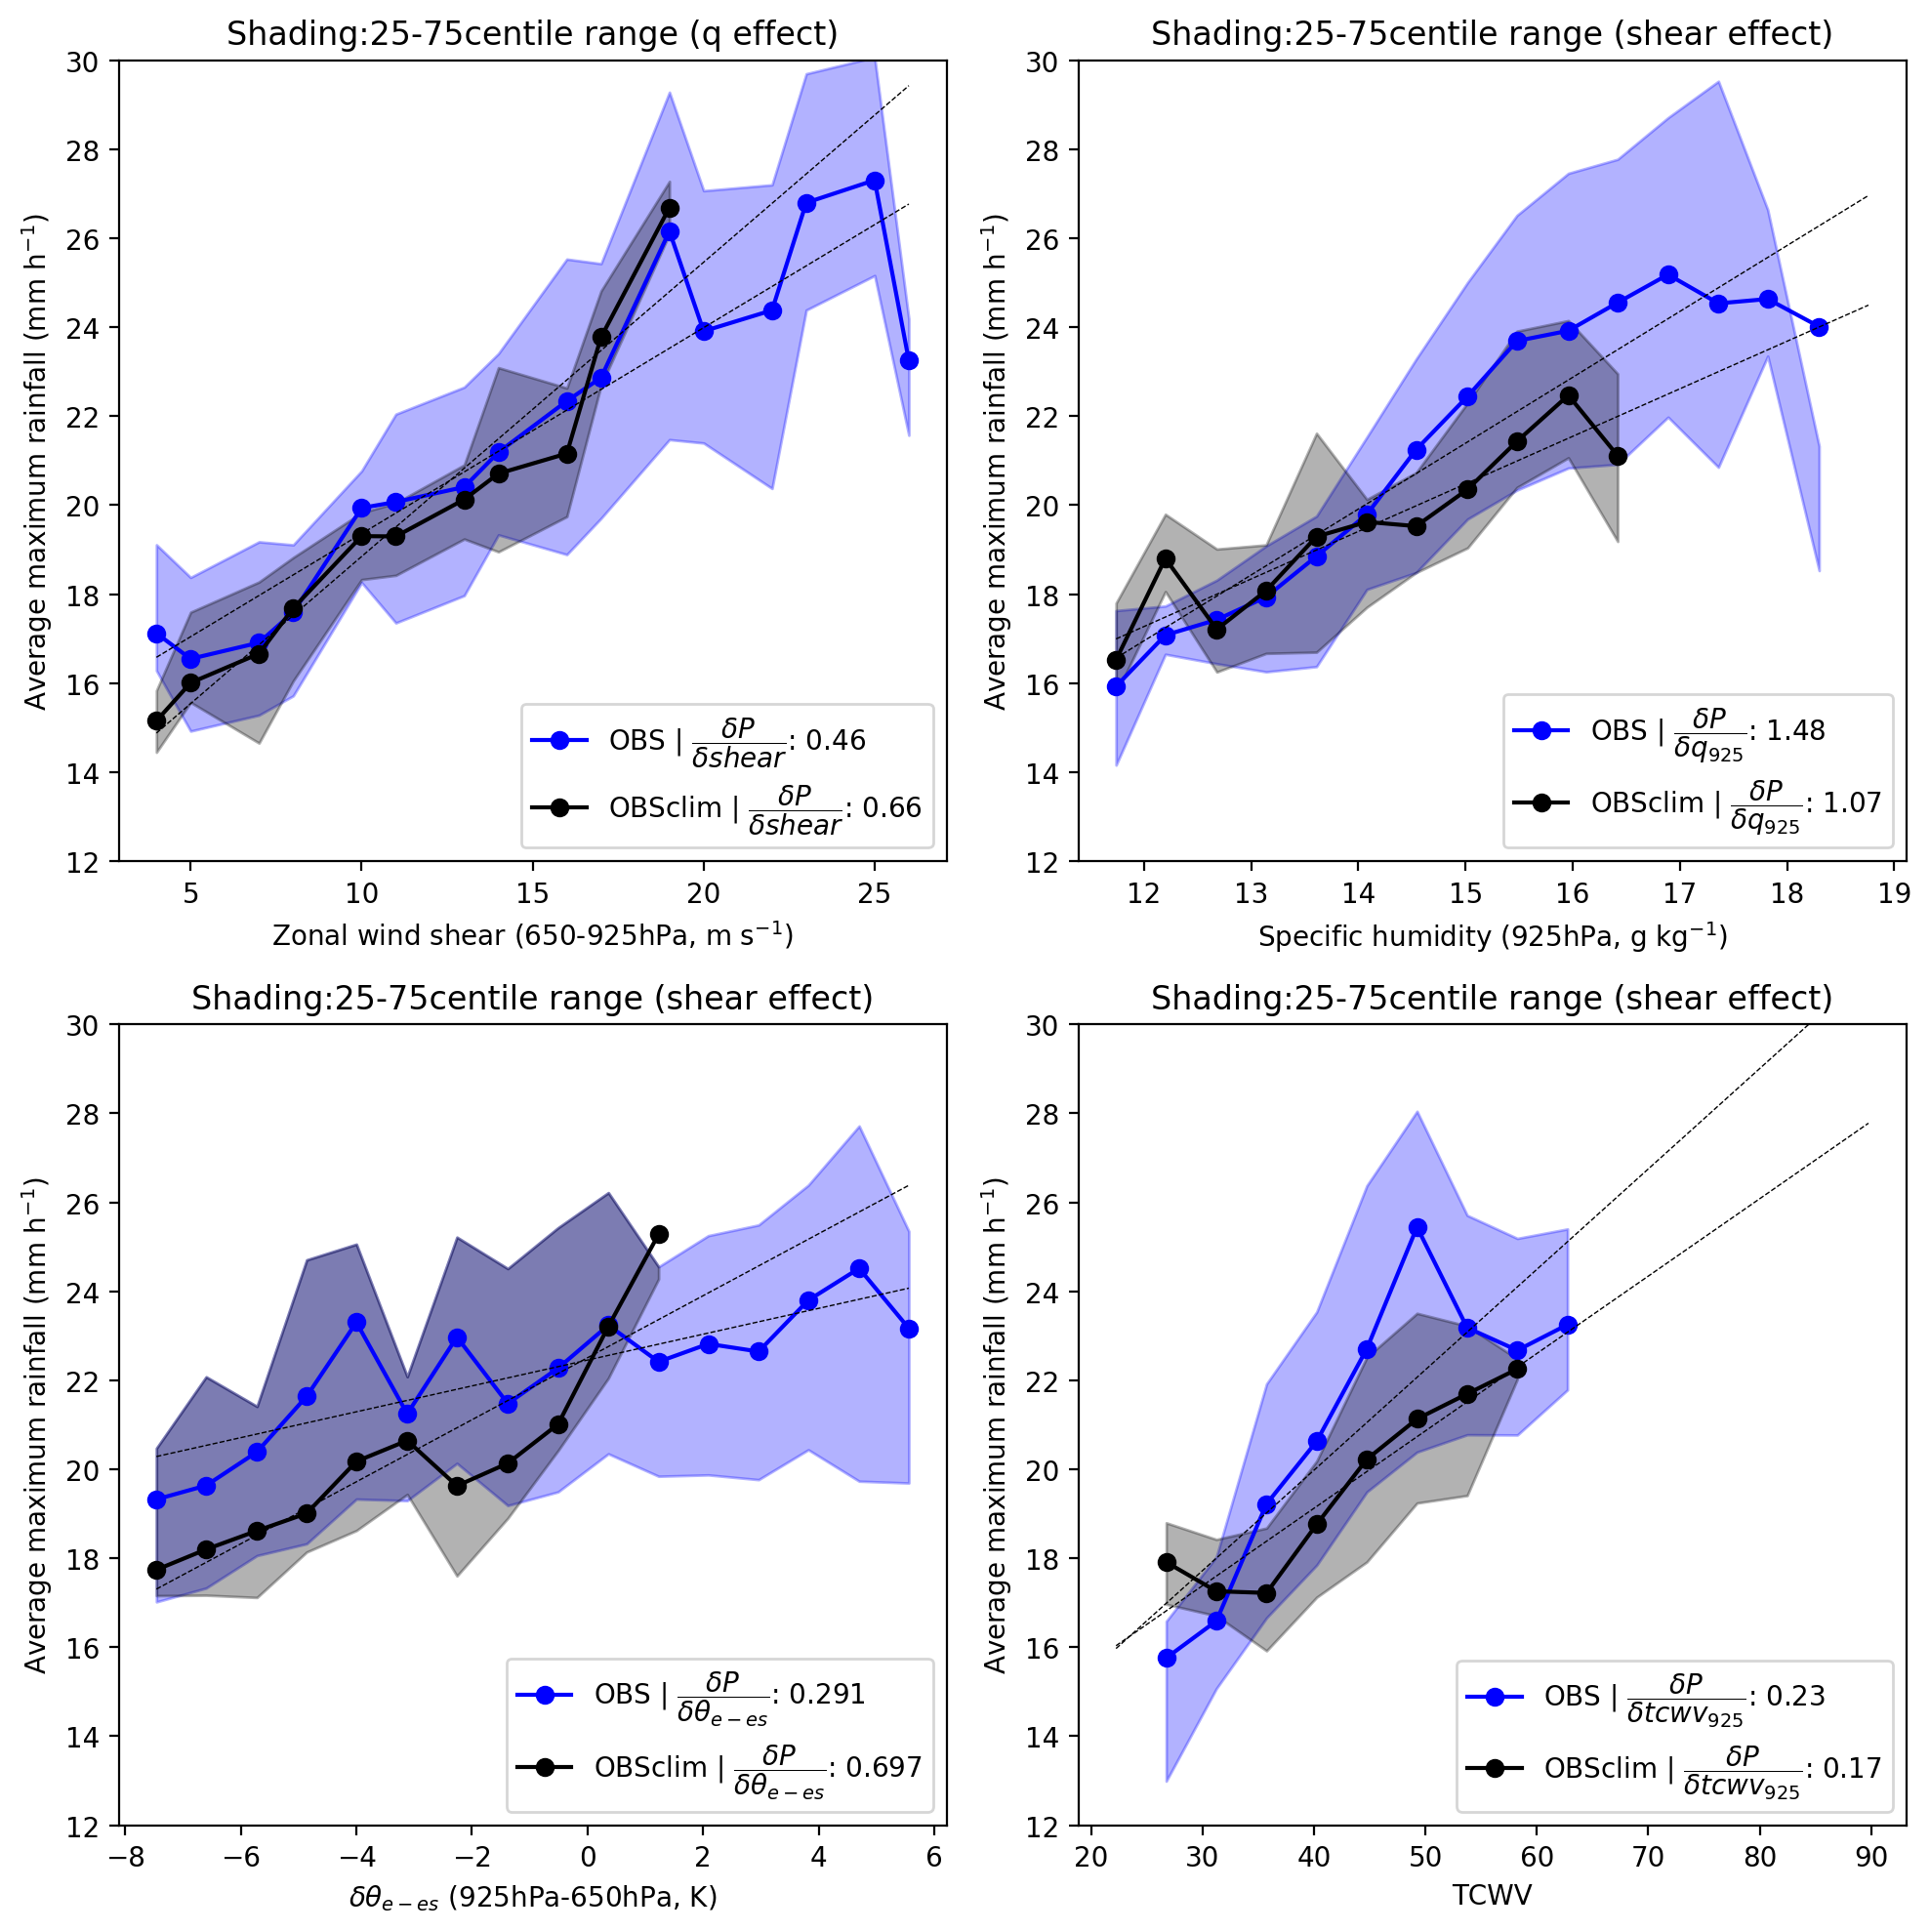

In [558]:
f = plt.figure(figsize=(10,10), dpi=200)
ax = f.add_subplot(221)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.plot(scollbins,pmeanc[0:-1], '-ko', label=r'OBSclim | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslopec,2)))
plt.fill_between(scollbins,p10[0:-1],p90[0:-1], color='blue', alpha=0.3)
plt.fill_between(scollbins,p10c[0:-1],p90c[0:-1], color='k', alpha=0.3)
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslopec*scollbins+PSinterceptc, linestyle='dashed', color='k', linewidth=0.5)

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(12,30)
#plt.ylim(15,33)
plt.legend(loc='lower right')

ax = f.add_subplot(222)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.plot(qcollbins,pqmeanc[0:-1], '-ko', label=r'OBSclim | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslopec,2)))
plt.fill_between(qcollbins,pq10[0:-1],pq90[0:-1], color='b', alpha=0.3)
plt.fill_between(qcollbins,pq10c[0:-1],pq90c[0:-1], color='k', alpha=0.3)
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslopec*qcollbins+PQinterceptc, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

plt.ylim(12,30)
#plt.ylim(15,33)
plt.legend(loc='lower right')

ax = f.add_subplot(223)
plt.plot(thcollbins,meantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope,3)))
plt.plot(thcollbins,meanthetac[0:-1], '-ko', label=r'OBSclim | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslopec,3)))
plt.fill_between(thcollbins,theta10[0:-1],theta90[0:-1], color='blue', alpha=0.3)
plt.fill_between(thcollbins,theta10c[0:-1],theta90[0:-1], color='k', alpha=0.3)
plt.plot(thcollbins,PTslope*thcollbins+PTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslopec*thcollbins+PTinterceptc, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(12,30)
#plt.ylim(1,33)
plt.legend(loc='lower right')

ax = f.add_subplot(224)
plt.plot(wvcollbins,pwmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(PWslope,2)))
plt.plot(wvcollbins,pwmeanc[0:-1], '-ko', label=r'OBSclim | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(PWslopec,2)))
plt.fill_between(wvcollbins,pw10[0:-1],pw90[0:-1], color='b', alpha=0.3)
plt.fill_between(wvcollbins,pw10c[0:-1],pw90c[0:-1], color='k', alpha=0.3)
plt.plot(wvcollbins,PWslope*wvcollbins+PWintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(wvcollbins,PWslopec*wvcollbins+PWinterceptc, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCWV')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(12,30)
#plt.ylim(1,33)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_fullWA_OBS_monthlyClim.png')

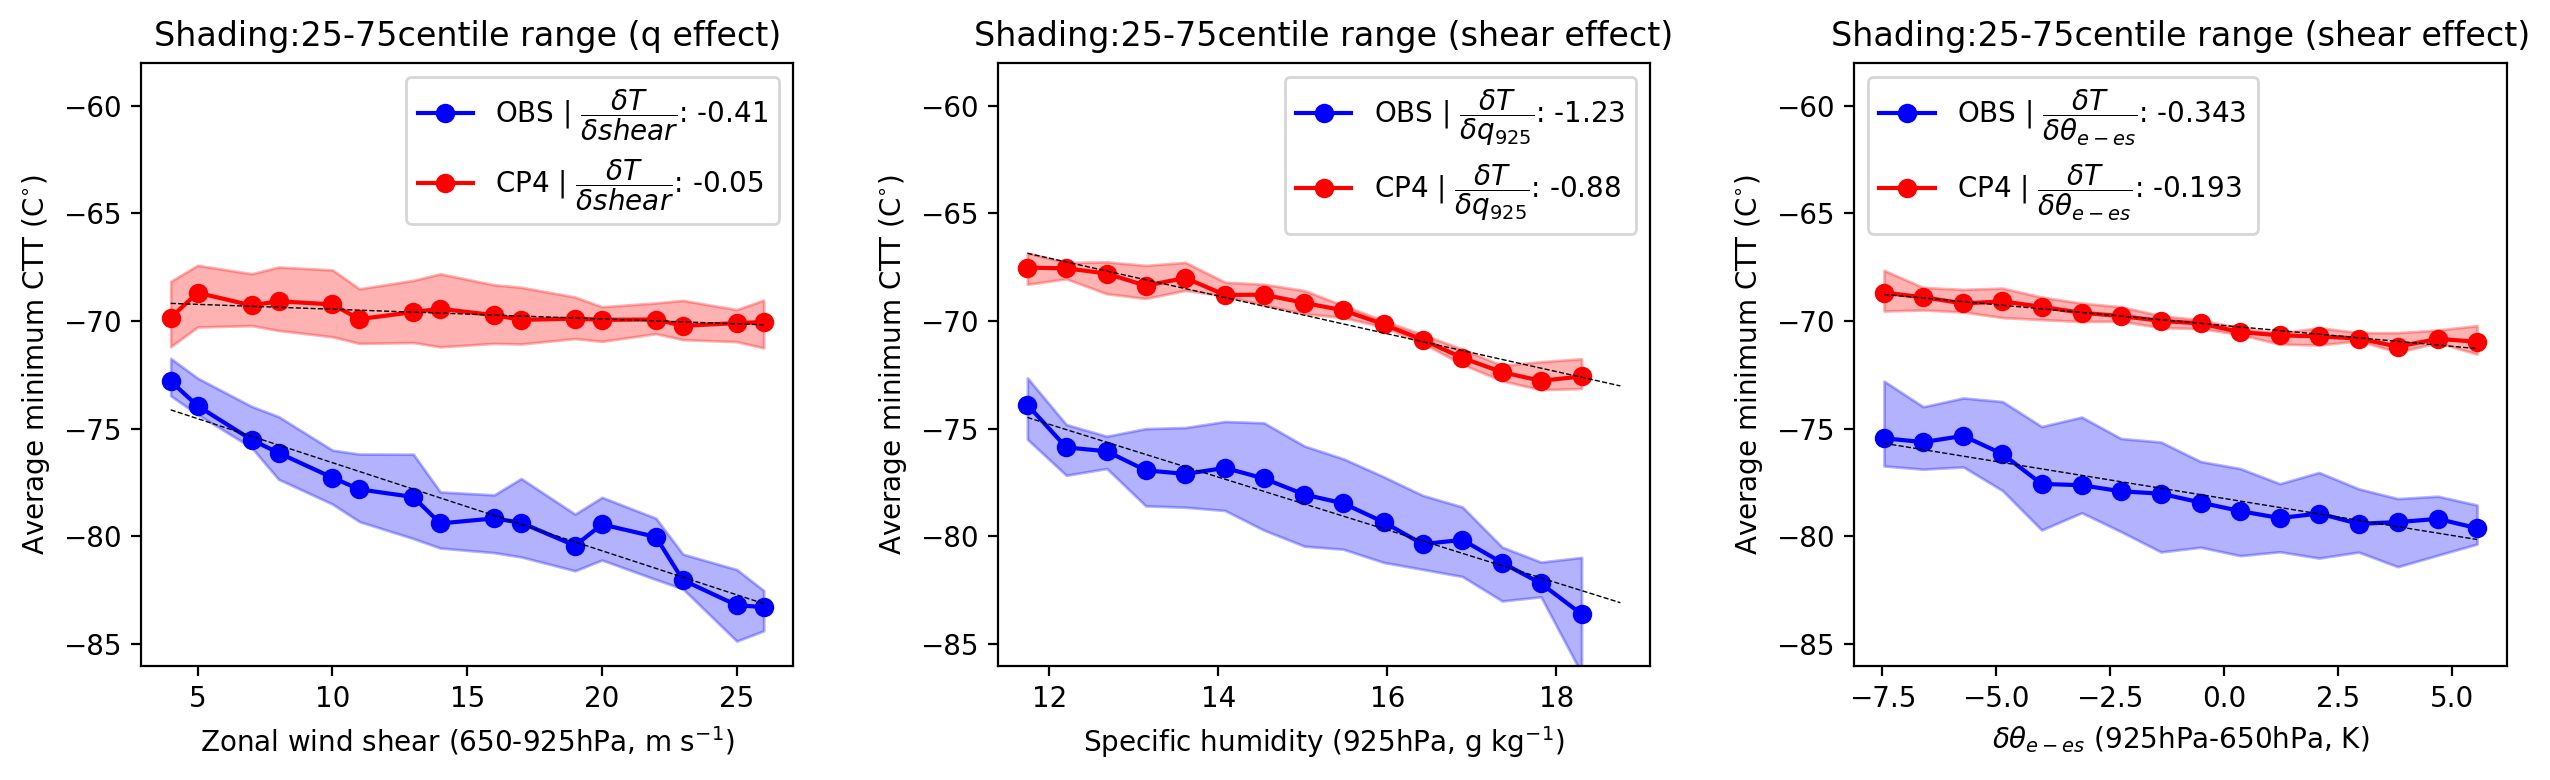

In [559]:
f = plt.figure(figsize=(13,4), dpi=200)
ax = f.add_subplot(131)

plt.plot(scollbins,tmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope,2)))
plt.fill_between(scollbins,t10[0:-1],t90[0:-1], color='blue', alpha=0.3)
plt.fill_between(scollbins,t104[0:-1],t904[0:-1], color='red', alpha=0.3)
plt.plot(scollbins,tmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope4,2)))
plt.plot(scollbins,TSslope*scollbins+TSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,TSslope4*scollbins+TSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper right')

ax = f.add_subplot(132)
plt.plot(qcollbins,tqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope,2)))
plt.fill_between(qcollbins,tq10[0:-1],tq90[0:-1], color='blue', alpha=0.3)
plt.fill_between(qcollbins,tq104[0:-1],tq904[0:-1], color='red', alpha=0.3)
plt.plot(qcollbins,tqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope4,2)))
plt.plot(qcollbins,TQslope*qcollbins+TQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,TQslope4*qcollbins+TQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper right')

ax = f.add_subplot(133)
plt.plot(thcollbins,tmeantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta \theta _{e-es}}$: ' + str(np.round(TTslope,3)))
plt.fill_between(thcollbins,ttheta10[0:-1],ttheta90[0:-1], color='blue', alpha=0.3)
plt.fill_between(thcollbins,ttheta104[0:-1],ttheta904[0:-1], color='red', alpha=0.3)
plt.plot(thcollbins,tmeantheta4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta T}{\delta \theta _{e-es}}$: ' + str(np.round(TTslope4,3)))
plt.plot(thcollbins,TTslope*thcollbins+TTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,TTslope4*thcollbins+TTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper left')

plt.tight_layout()
#f.savefig(cnst.network_data +'figs/CLOVER/OBS_CP4_lineplot_'+tag+'_15km_tmin.png')

In [560]:
# sensitivity = {}
# sensitivity['shear_slope'] = slope
# sensitivity['qslope'] = qslope 
# pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

In [561]:
data_list = [tmin_dic_obs, tmin_dic_cp4, area_dic,prcp_dic_obs, prcp_dic_cp4, area_dic_cp4]

0
1
2
3
4
5


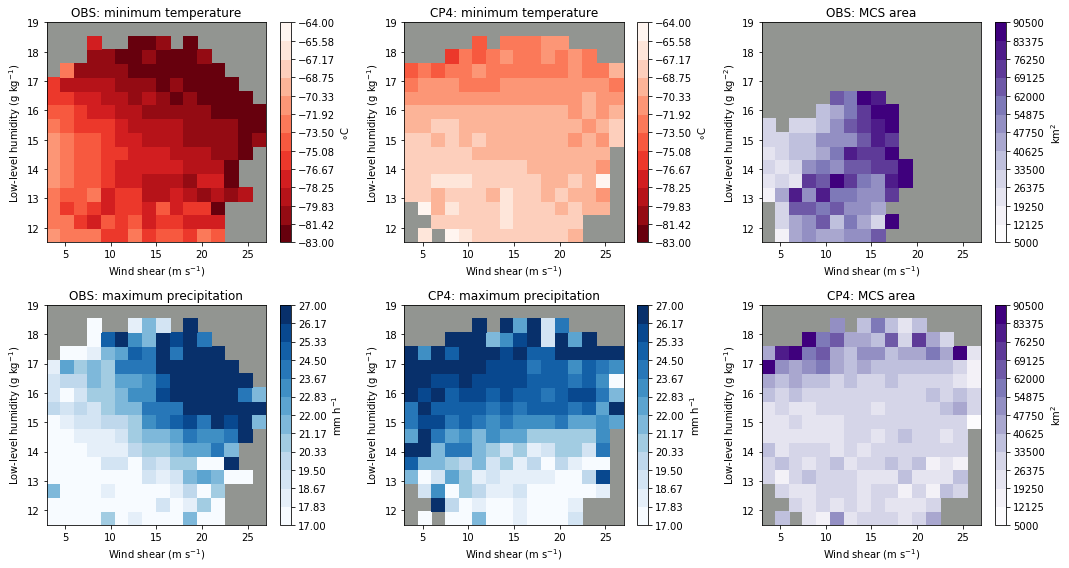

In [564]:
hist2d_six_area(data_list, valid=True)

In [98]:
data_list = [thetatmin_dic_obs, thetatmin_dic_cp4, thetaprcp_dic_obs, thetaprcp_dic_cp4]

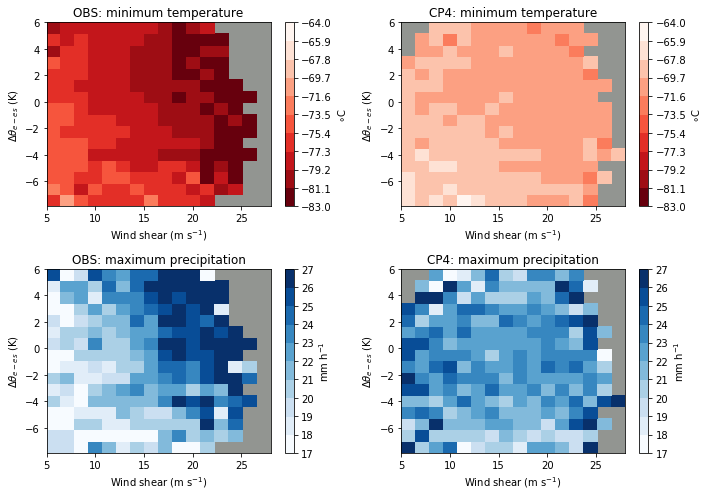

In [99]:
hist2d_quatro(data_list, valid=True)